# Capstone Project — Part I: California Housing Regression

**Goal:**  
Deliver a reproducible regression workflow on the *California Housing* dataset (`fetch_california_housing`) prior to the deep-learning units of *Deep Learning Basics with PyTorch*.

---

## Objectives
1. **Data Familiarization** — Explore data, distributions, and feature–target relationships.  
2. **Splits & Preprocessing** — Build reproducible pipelines with standardized numeric transforms.  
3. **Baseline Modeling** — Benchmark linear (Ridge) and nonlinear (HistGradientBoosting) regressors.  
4. **Diagnostics & Iteration** — Evaluate residuals, learning curves, and key drivers.  
5. *(Stretch)* Prepare for a PyTorch MLP baseline (Part II).

---

## Deliverables
- Clean exploratory EDA  
- Reproducible pipelines and notebooks  
- Metric dashboard and diagnostic plots  
- Proposal for how Part II (deep learning) will extend the project  

---

*Notebook structure inspired by the official Capstone Project Part I slides (Dr. Yves Hilpisch, The Python Quants GmbH).*


# Data familiarization
## Setup & Data Loading

In [1]:
# --- 0. Repro + imports ---
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

plt.rcParams["figure.dpi"] = 130
sns.set_theme(style="whitegrid", palette="deep")


In [2]:
# --- 1. Load dataset & quick sanity checks ---

cal = fetch_california_housing(as_frame=True)

X_raw = cal.data.copy()
y_raw = cal.target.rename("MedHouseVal")  # $100k units
FEATURES = X_raw.columns.tolist()

# unified frame for quick EDA
df = pd.concat([X_raw, y_raw], axis=1)

print(f"Rows: {df.shape[0]:,}  |  Cols: {df.shape[1]}")
print("Features:", FEATURES)
print("Target:", y_raw.name, "(units: $100k)")

# missing values check (should be none in this dataset)
na = df.isna().sum()
assert na.sum() == 0, f"Unexpected NaNs:\n{na[na>0]}"

display(df.head(10))
display(df.describe().T)

Rows: 20,640  |  Cols: 9
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal (units: $100k)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


## Exploratory Data Analysis (EDA)

### Feature Distributions, Spatial Patterns & Baseline Diagnostics

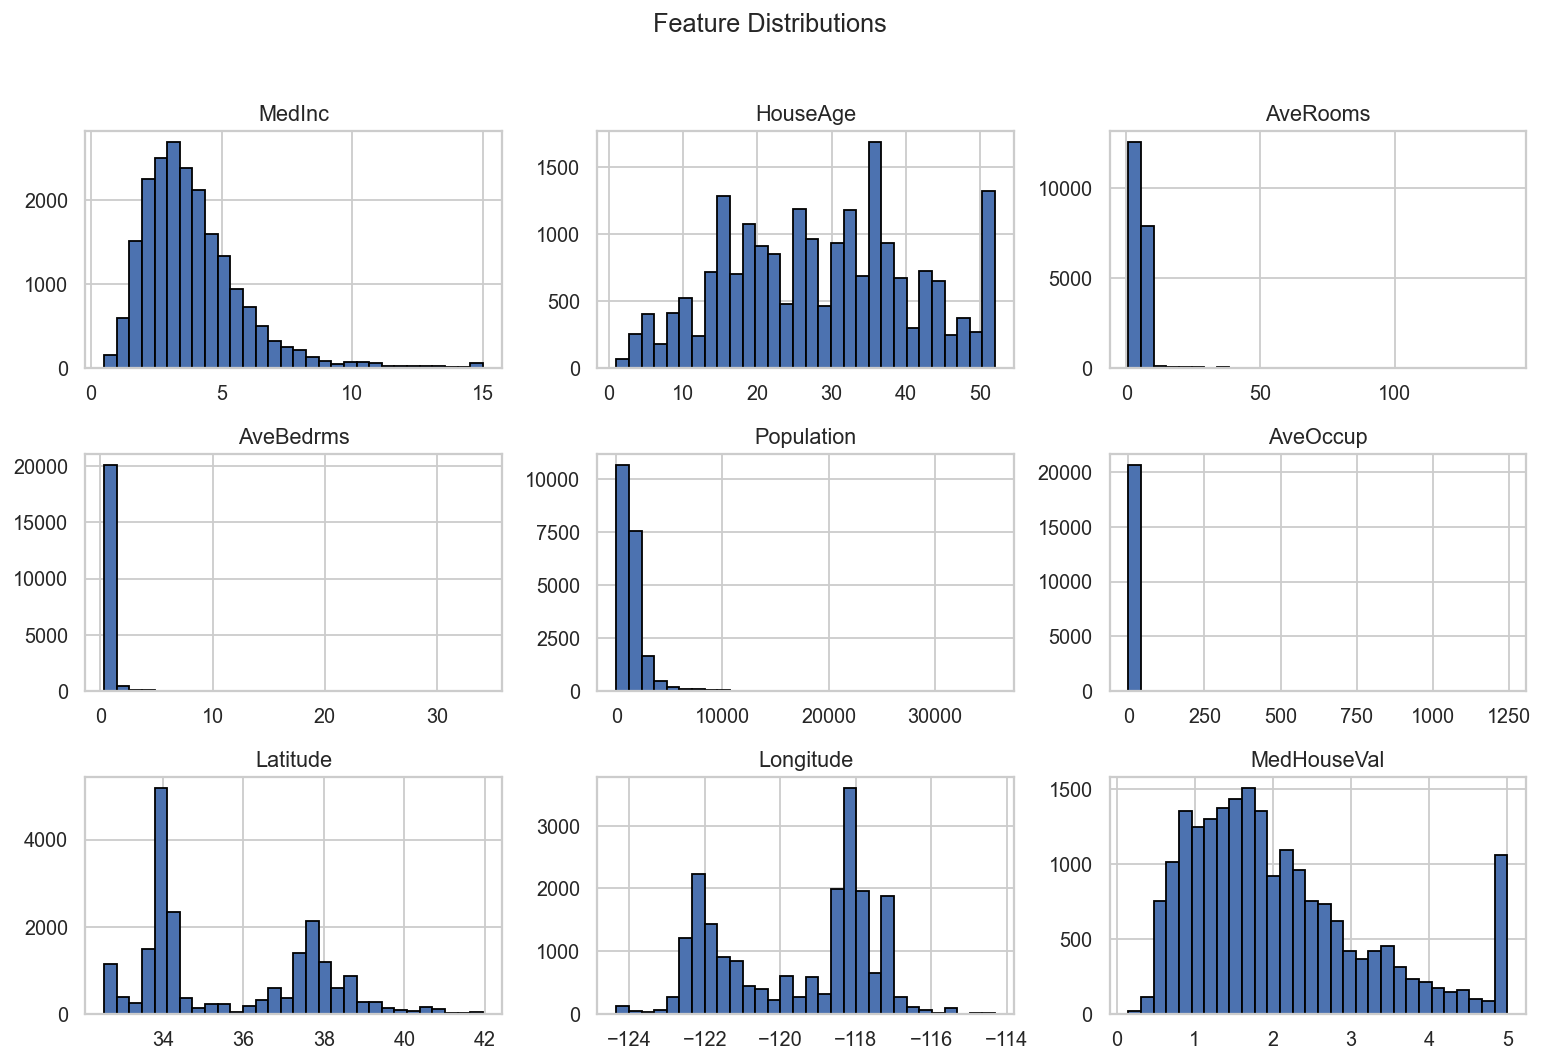

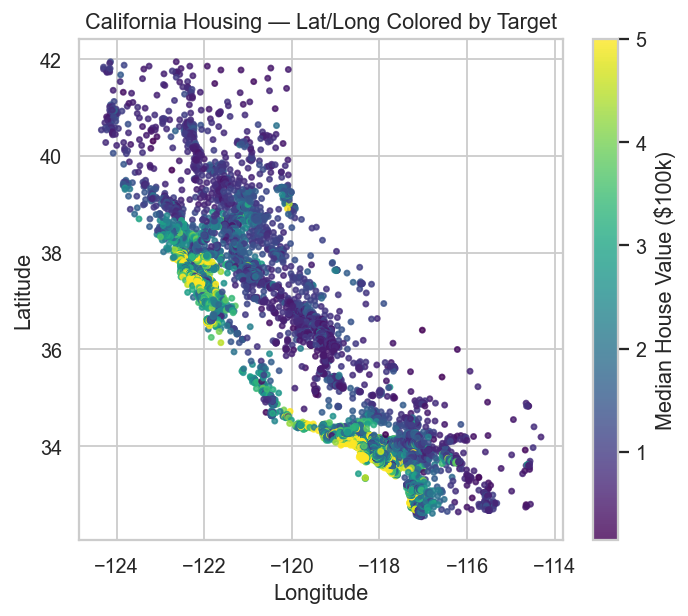

Baseline MAE: 0.912 | RMSE: 1.154


In [3]:
# --- 2. Exploratory plots: distributions, spatial layout & baseline check ---

# Feature distributions
df.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Latitude/Longitude scatter colored by target
plt.figure(figsize=(6, 5))
sc = plt.scatter(
    df["Longitude"], df["Latitude"],
    c=df["MedHouseVal"], cmap="viridis", s=8, alpha=0.8
)
plt.colorbar(sc, label="Median House Value ($100k)")
plt.title("California Housing — Lat/Long Colored by Target", fontsize=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Baseline (mean predictor) – purely diagnostic, not a model
y = df["MedHouseVal"].values
y_mean = np.full_like(y, y.mean(), dtype=float)

mae = mean_absolute_error(y, y_mean)
rmse = np.sqrt(mean_squared_error(y, y_mean))  # compatible across sklearn versions

print(f"Baseline MAE: {mae:.3f} | RMSE: {rmse:.3f}")

### Exploratory Observations

**Feature Distributions**
- `MedInc` (median income) is **right-skewed**, suggesting a possible log-transform later to stabilize variance.  
- `AveRooms`, `AveBedrms`, and `AveOccup` show **long-tailed distributions** — likely driven by a few extreme census tracts.  
- `HouseAge` is **roughly uniform**, while `Population` has a heavy right tail.  
- Geographic features (`Latitude`, `Longitude`) confirm strong **spatial clustering**, aligning with California’s dense coastal cities.

**Spatial Patterns**
- The **latitude/longitude scatter** reveals a clear coastal concentration of higher house values (yellow regions), roughly tracing major metro areas (SF Bay, LA Basin, San Diego).  
- Inland regions show consistently lower values, indicating a **geographically structured target** that might challenge purely linear models.

**Baseline Metrics**
- A simple **mean predictor** yields:  
  - MAE ≈ **0.91**  
  - RMSE ≈ **1.15**  
- This represents the “difficulty floor” — any useful model must perform meaningfully better than this baseline.

---

Overall, the data show **strong spatial effects** and **non-normal feature distributions**, motivating future transformations (e.g., scaling, logs) and possibly nonlinear modeling (HGB, neural networks) in later stages.


### Correlations & Key Driver Scatterplots

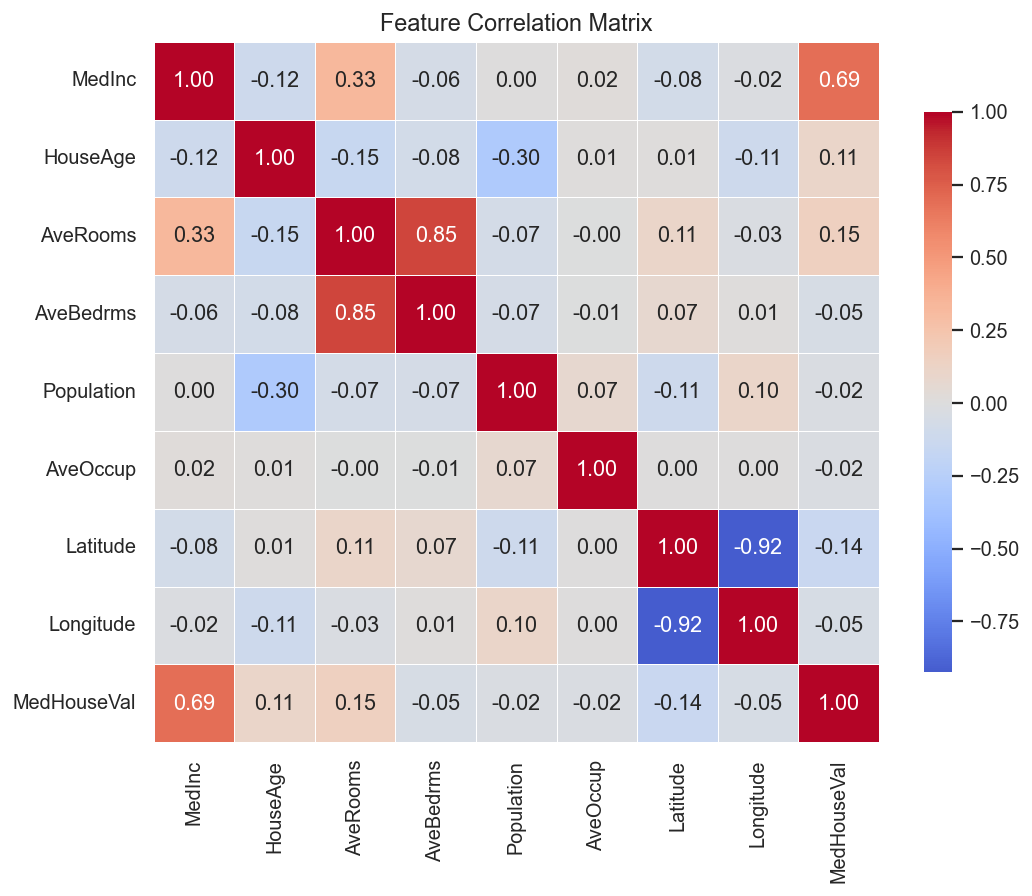

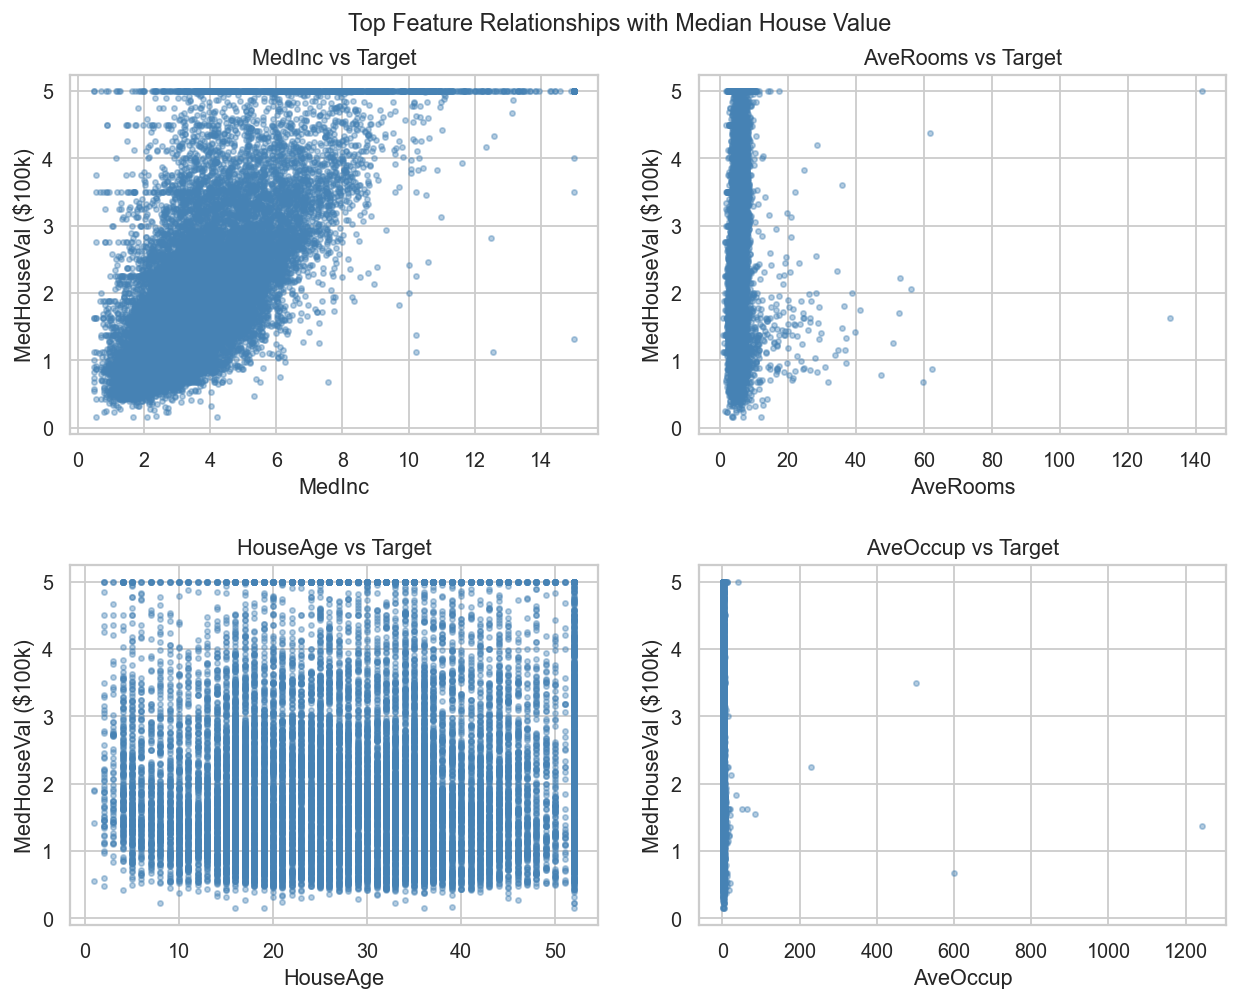

In [4]:
# --- 3. Correlations & key driver scatterplots ---

# Correlation matrix
corr = df.corr(numeric_only=True)
plt.figure(figsize=(9, 7))
sns.heatmap(
    corr, cmap="coolwarm", center=0,
    annot=True, fmt=".2f", linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Matrix", fontsize=13)
plt.show()

# Scatter vs. target for top correlated drivers
top_features = (
    corr["MedHouseVal"]
    .drop("MedHouseVal")
    .sort_values(ascending=False)
    .head(4)
    .index
)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ax, feat in zip(axs.flat, top_features):
    ax.scatter(df[feat], df["MedHouseVal"], alpha=0.4, s=8, color="steelblue")
    ax.set_xlabel(feat)
    ax.set_ylabel("MedHouseVal ($100k)")
    ax.set_title(f"{feat} vs Target")

plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.92)  # prevents title overlap
plt.suptitle("Top Feature Relationships with Median House Value", fontsize=13)
plt.show()

### Correlations and Key Relationships

**Correlation Structure**
- The target (`MedHouseVal`) shows its strongest positive correlation with **median income (`MedInc`, r ≈ +0.69)** — confirming that income is the most direct linear driver of home values.  
- Moderate correlations appear for **average rooms (`AveRooms`)** and **longitude** (slightly negative), while `Latitude` and `Longitude` are **highly correlated (r ≈ −0.92)**, reflecting California’s north–south coastal geography.  
- Most other variables (`Population`, `AveOccup`) contribute little linear signal and may instead encode **nonlinear or interaction effects**.

**Feature Relationships**
- `MedInc` displays a **clear positive, nonlinear relationship** with house value — prices rise sharply with income until saturating at the top decile.  
- `AveRooms` and `AveOccup` show **high dispersion and outliers**, suggesting feature scaling and potential trimming will be necessary before modeling.  
- `HouseAge` shows **no obvious linear trend**, though a mild banding effect indicates a mix of new and old neighborhoods with varying value ranges.

---

**Takeaway:**  
Median income dominates as the key explanatory variable, while geographic coordinates and room-related ratios capture secondary, spatially dependent effects.  
These insights justify our upcoming step: building **preprocessing pipelines** that standardize and potentially transform skewed numeric features before fitting baseline models.


### Pairplot of top correlated features

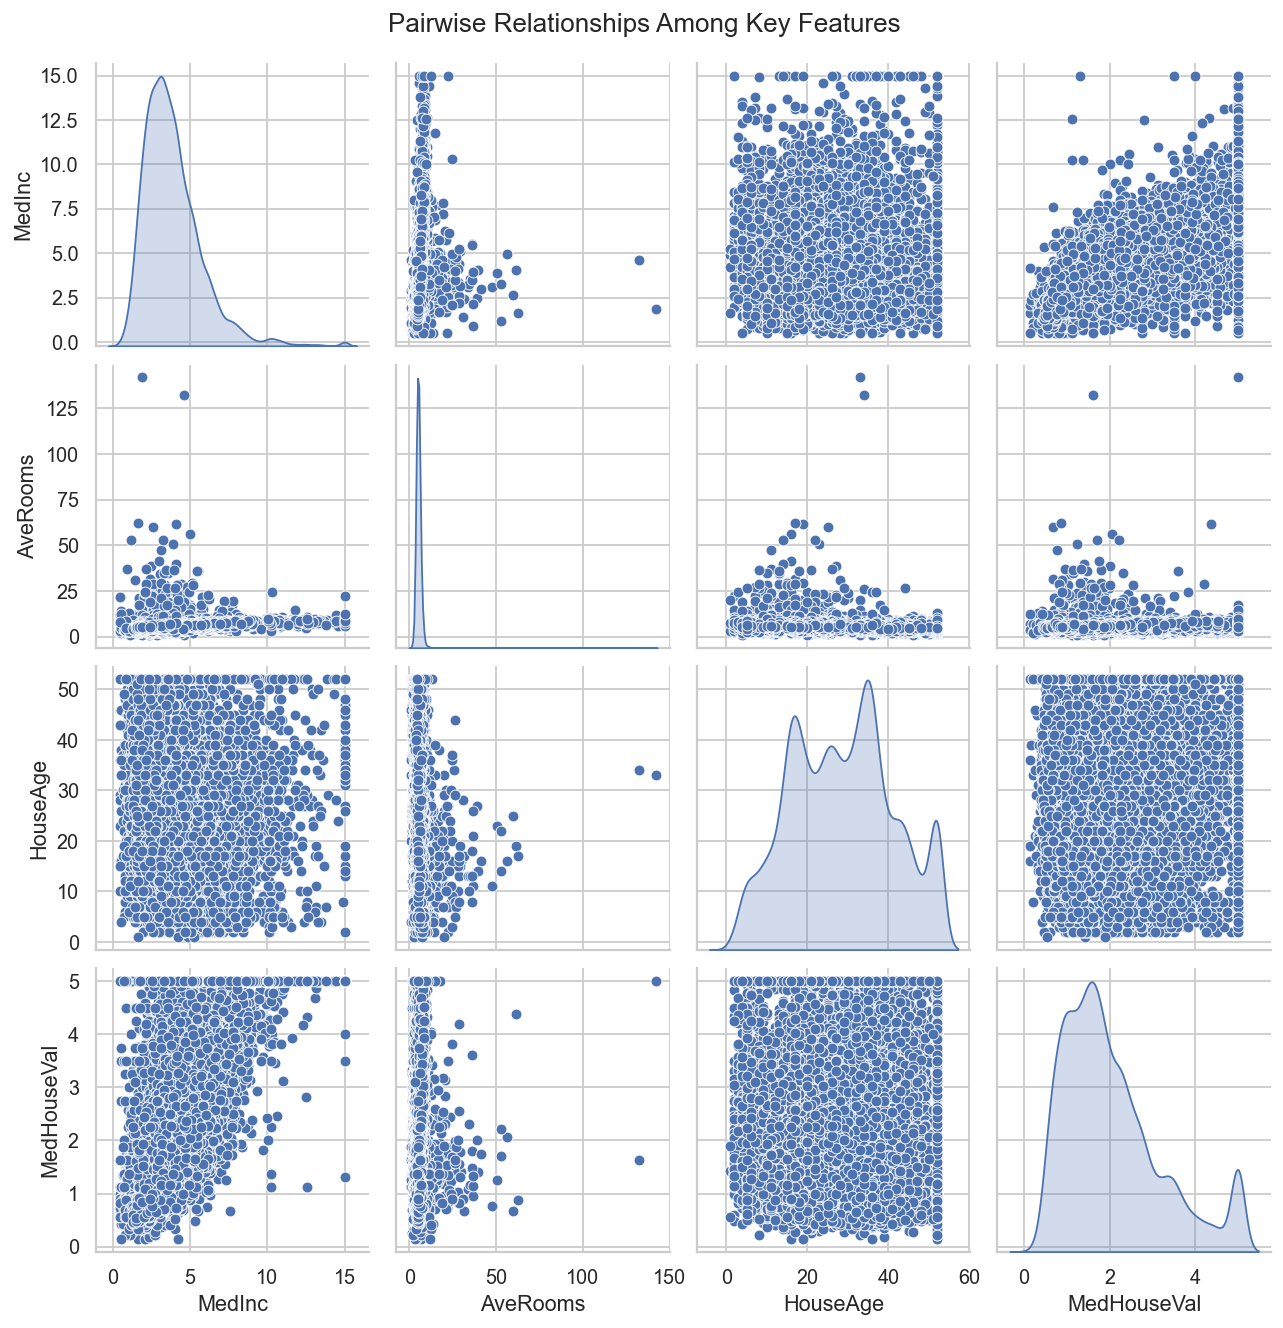

In [5]:
sns.pairplot(df[["MedInc", "AveRooms", "HouseAge", "MedHouseVal"]], diag_kind="kde")
plt.suptitle("Pairwise Relationships Among Key Features", y=1.02)
plt.show()

### Pairwise Relationships Among Top Features

The pairplot reinforces earlier correlation findings and adds distributional context:

- **`MedInc` vs `MedHouseVal`** — clear upward trend with diminishing slope at high incomes, indicating a **nonlinear, saturating relationship** between income and housing value.  
- **`AveRooms`** — exhibits extreme right-skew; most tracts cluster under 10 rooms, but a few outliers reach 100+, which could distort regression coefficients if not scaled or clipped.  
- **`HouseAge`** — roughly uniform, though certain bands (newer vs. older homes) dominate in distinct value ranges.  
- **Marginal Distributions (diagonals)** — confirm heavy skew in `MedInc` and `AveRooms`, motivating transformations (e.g., log or power) before modeling.

---

**Interpretation:**  
These relationships suggest that **linear models may underfit** without appropriate feature scaling and transformations.  
Nonlinear approaches such as **HistGradientBoosting** (used later) or a small **MLP** can capture these richer interactions more naturally.


### Target vs Latitude/Longitude (regional pricing heatmap)

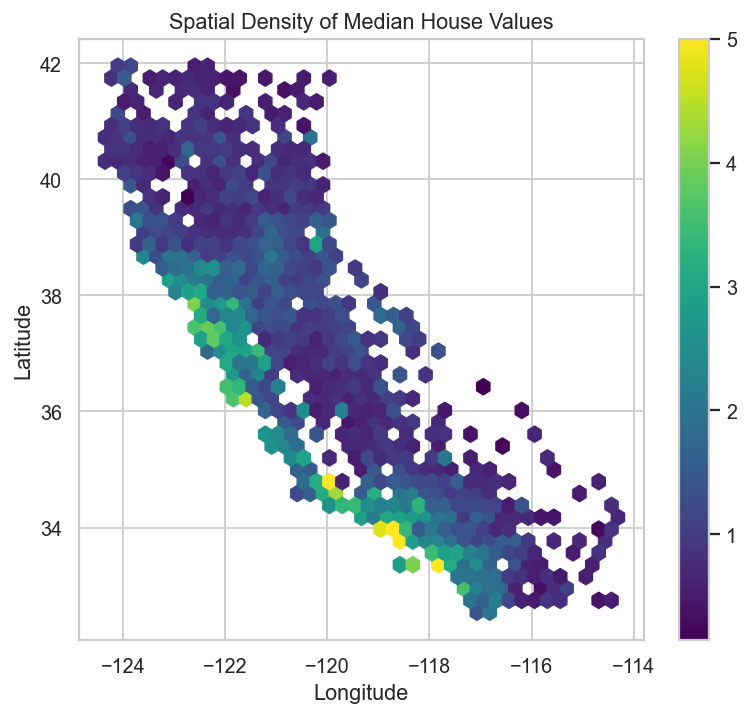

In [6]:
df.plot(
    kind="hexbin",
    x="Longitude", y="Latitude",
    C="MedHouseVal", gridsize=40, cmap="viridis",
    sharex=False, figsize=(7, 6)
)
plt.title("Spatial Density of Median House Values")
plt.show()

### Spatial Density of Median House Values

This hexbin heatmap highlights the **regional structure of California’s housing prices**:

- **Coastal clusters** (notably around Los Angeles, San Francisco, and San Diego) exhibit the **highest median house values**, shown in lighter yellow tones.  
- **Inland and northern regions** display darker tones, indicating systematically lower prices.  
- The sharp **north–south gradient** along the coastline mirrors California’s economic geography — dense urban hubs with higher incomes and limited land availability versus lower-cost inland areas.

**Interpretation:**  
The strong spatial heterogeneity suggests that purely tabular models may struggle to capture location-driven effects unless latitude and longitude are explicitly modeled (e.g., polynomial expansion, spatial embeddings, or tree-based learners).  

This further reinforces the need for **nonlinear models** or **feature engineering** to capture geographic price interactions beyond simple linear regression.
